# Compare annotations between nuclei & cells (= comparison table cells / table nuclei / table combined) using v2 for label combined

In [1]:
import os
import pandas as pd
import json
from pySankey.sankey import sankey
import seaborn as sns
import matplotlib.pyplot as plt

## Helper functions

In [2]:
def generate_comparison_summary(adata_obs_merge):

    comparisons = [
        ("final_label_cells", "final_label_nuclei"),
        ("final_label_cells", "final_label_nuclei", True),
        ("final_label_cells", "final_label_combined"),
        ("final_label_cells", "final_label_combined", True),
        ("final_label_nuclei", "final_label_combined"),
        ("final_label_nuclei", "final_label_combined", True),
    ]

    def calculate_equal(df, label1, label2, skip_less10=False):
        if skip_less10:
            df = df[(df[label1] != "Less10") & (df[label2] != "Less10")]
        equal_count = (df[label1] == df[label2]).sum()
        total_count = len(df)
        return round((equal_count / total_count) * 100, 1) if total_count > 0 else 0

    summary_data = []
    slide_ids = adata_obs_merge['slide_id'].unique()

    for slide_id in list(slide_ids) + ["all"]:
        slide_df = adata_obs_merge if slide_id == "all" else adata_obs_merge[adata_obs_merge['slide_id'] == slide_id]
        row = {"slide_id": slide_id}

        for comparison in comparisons:
            label1, label2 = comparison[0], comparison[1]
            skip_less10 = comparison[2] if len(comparison) > 2 else False
            col_name = f"{label1} vs {label2}" + (" (no Less10)" if skip_less10 else "")
            row[col_name] = calculate_equal(slide_df, label1, label2, skip_less10)

        summary_data.append(row)
    
    df_summary = pd.DataFrame(summary_data)


    df_raw = pd.DataFrame(summary_data)
    all_row = df_raw[df_raw['slide_id'] == 'all']
    slide_rows = df_raw[df_raw['slide_id'] != 'all']

    for col in df_raw.columns:
        if col != 'slide_id':
            all_val = all_row[col].values[0]
            std_val = slide_rows[col].std()
            print(f"{col}: All accuracy = {all_val}%, Std = {std_val:.2f}")


    return df_summary.style.background_gradient(cmap="coolwarm", axis=None)

In [3]:
def sankey_plot(adata_obs_merge, label1, label2, slide_ids=None, skip_Less10=True):

    if slide_ids:
        adata_obs_merge_plot = adata_obs_merge[adata_obs_merge['slide_id'].isin(slide_ids)].copy()
    else:
        adata_obs_merge_plot = adata_obs_merge.copy()

    if skip_Less10:
        adata_obs_merge_plot = adata_obs_merge_plot[(adata_obs_merge_plot[label1] != "Less10") & (adata_obs_merge_plot[label2] != "Less10")]

    print(' '*12 + str(label1) + ' '*50 + label2)
    sankey(adata_obs_merge_plot[label1], adata_obs_merge_plot[label2], fontsize=10)

In [4]:
def crosstab_heatmap(adata_obs_merge, label1, label2, slide_ids=None, normalize='index'): # for normalize, choose between 'index', 'columns', 'all', or None

    if slide_ids:
        adata_obs_merge_tab = adata_obs_merge[adata_obs_merge['slide_id'].isin(slide_ids)].copy()
    else:
        adata_obs_merge_tab = adata_obs_merge.copy()
    
    cross_tab = pd.crosstab(adata_obs_merge_tab[label1], adata_obs_merge_tab[label2], normalize=normalize).round(2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cross_tab, annot=True, cmap="Blues", cbar=False)
    plt.title(f'Normalized using: {normalize}')
    plt.ylabel(label1)
    plt.xlabel(label2)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Analyze

In [6]:
adata_obs_merge = pd.read_csv('/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/annots/adata_compare_annots_v2.csv')
adata_obs_merge

slide_id     cell_id                 label1_nuclei  \
0         bone_marrow_s0  aaaaaaaa-1                       B_blast   
1         bone_marrow_s0  aaaaaaab-1                             T   
2         bone_marrow_s0  aaaaaaac-1                        less10   
3         bone_marrow_s0  aaaaaaad-1  Proliferating_leukemic_blast   
4         bone_marrow_s0  aaaaaaae-1                        less10   
...                  ...         ...                           ...   
11207684       tonsil_s1  aaandahp-1                             B   
11207685       tonsil_s1  aaandaia-1                             T   
11207686       tonsil_s1  aaandaib-1                             T   
11207687       tonsil_s1  aaandaic-1        Monocyte/Macrophage/DC   
11207688       tonsil_s1  aaandaid-1                             T   

         final_label_nuclei            label1_cells         final_label_cells  \
0                  B_Plasma              Fibroblast  Fibroblast_Myofibroblast   
1                      T_NK            B_progenitor                  B_Plasma   
2                    Less10                  less10                    Less10   
3                 Stem_like            B_progenitor                  B_Plasma   
4                    Less10                  less10                    Less10   
...                     ...                     ...                       ...   
11207684           B_Plasma                       B                  B_Plasma   
11207685               T_NK                       T                      T_NK   
11207686               T_NK                       T                      T_NK   
11207687            Myeloid  Monocyte/Macrophage/DC                   Myeloid   
11207688               T_NK  Monocyte/Macrophage/DC                   Myeloid   

         PanNuke_label  PanNuke_proba      final_label_combined  
0         Inflammatory       0.416268  Fibroblast_Myofibroblast  
1           Neoplastic       0.311243                  B_Plasma  
2           Neoplastic       0.754624                    Less10  
3           Neoplastic       0.421805  Fibroblast_Myofibroblast  
4           Neoplastic       0.347782                    Less10  
...                ...            ...                       ...  
11207684    Neoplastic       0.427500                  B_Plasma  
11207685  Inflammatory       0.893939                      T_NK  
11207686  Inflammatory       0.814590                      T_NK  
11207687  Inflammatory       0.330479                   Myeloid  
11207688    Background       1.000000                      T_NK  

[11207689 rows x 9 columns]

In [7]:
comparison_summary = generate_comparison_summary(adata_obs_merge)
comparison_summary

final_label_cells vs final_label_nuclei: All accuracy = 74.7%, Std = 11.10
final_label_cells vs final_label_nuclei (no Less10): All accuracy = 80.4%, Std = 8.91
final_label_cells vs final_label_combined: All accuracy = 84.0%, Std = 6.44
final_label_cells vs final_label_combined (no Less10): All accuracy = 83.3%, Std = 7.40
final_label_nuclei vs final_label_combined: All accuracy = 76.8%, Std = 11.38
final_label_nuclei vs final_label_combined (no Less10): All accuracy = 82.9%, Std = 10.67


            final_label_cells                                                  final_label_nuclei


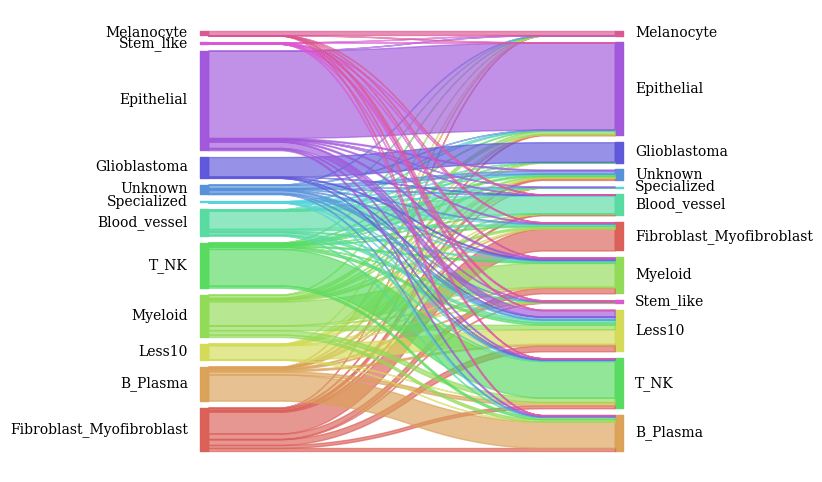

In [7]:
sankey_plot(adata_obs_merge, 'final_label_cells', 'final_label_nuclei', slide_ids=[], skip_Less10=False)

            final_label_cells                                                  final_label_combined


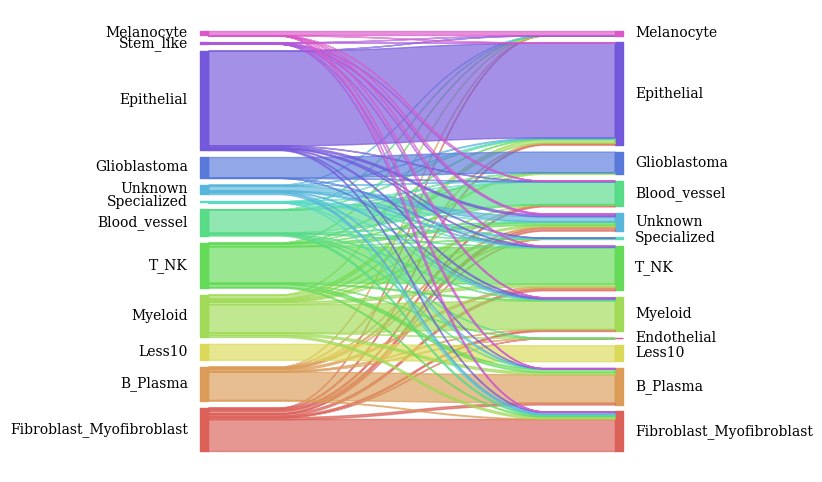

In [8]:
sankey_plot(adata_obs_merge, 'final_label_cells', 'final_label_combined', slide_ids=[], skip_Less10=False)

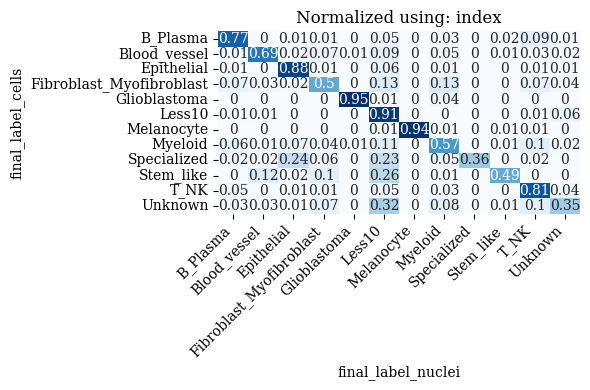

================================================== bone_marrow_s0 ==================================================


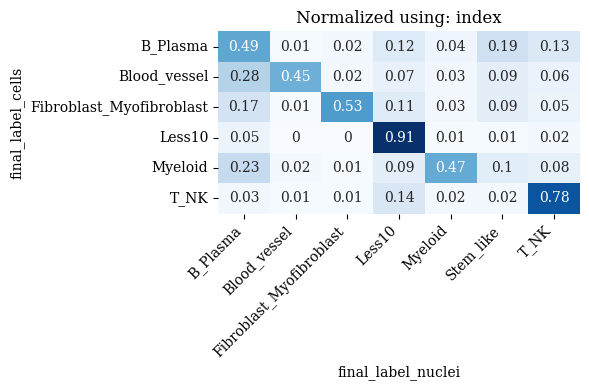

================================================== bone_marrow_s1 ==================================================


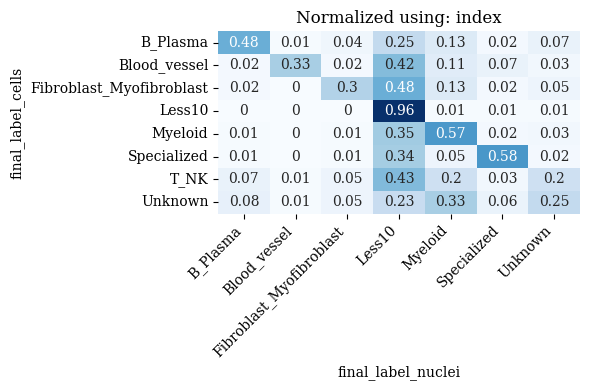

================================================== bone_s0 ==================================================


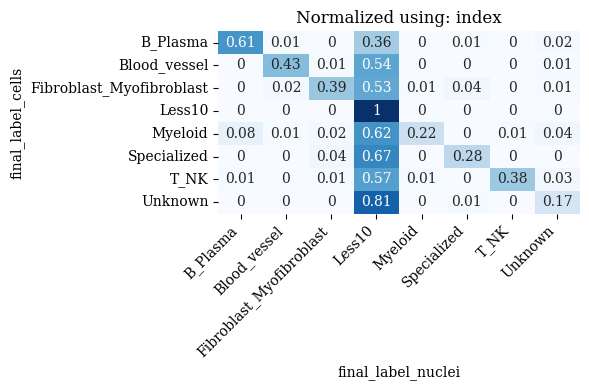

================================================== brain_s0 ==================================================


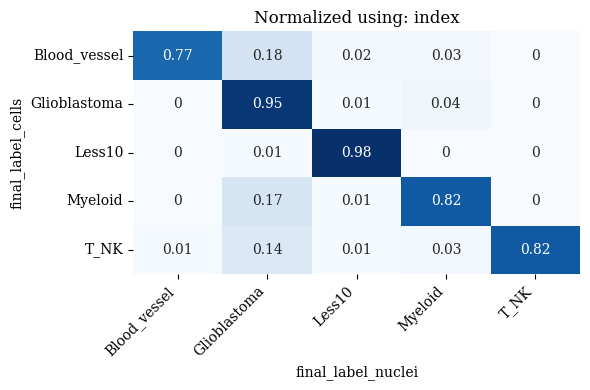

================================================== breast_s0 ==================================================


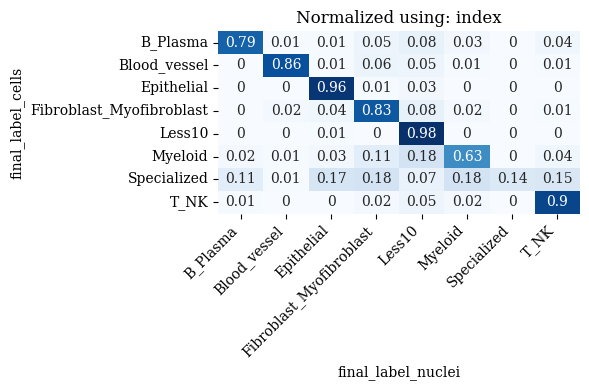

================================================== breast_s1 ==================================================


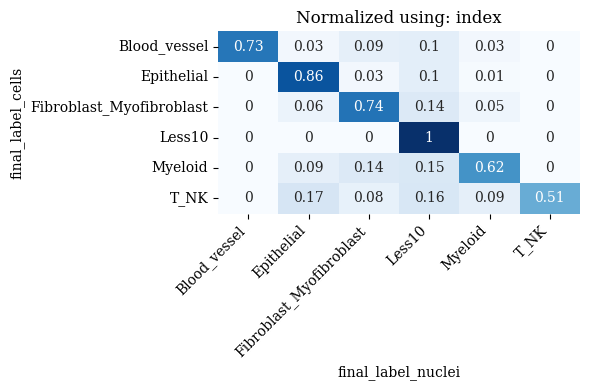

================================================== breast_s3 ==================================================


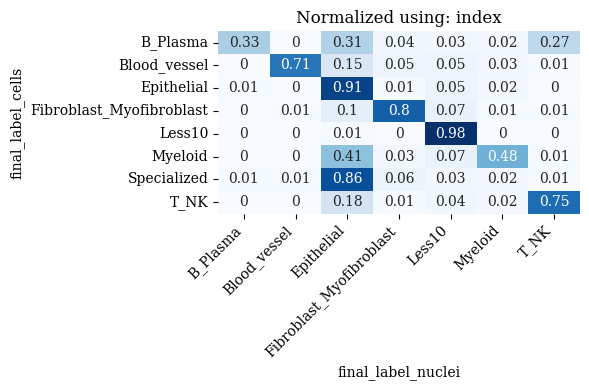

================================================== breast_s6 ==================================================


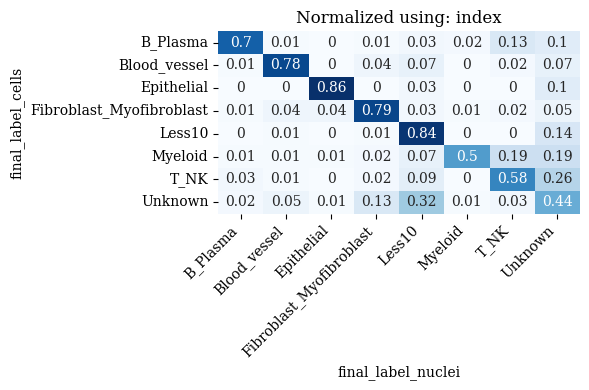

================================================== cervix_s0 ==================================================


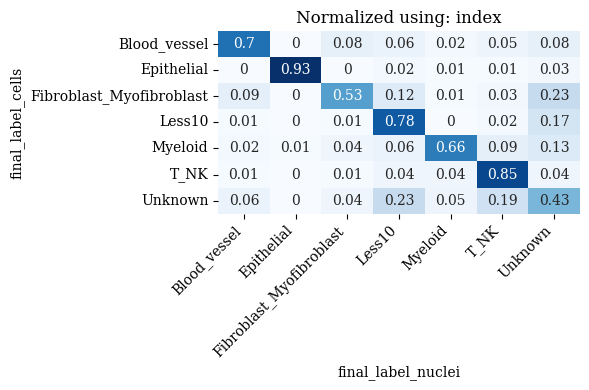

================================================== colon_s1 ==================================================


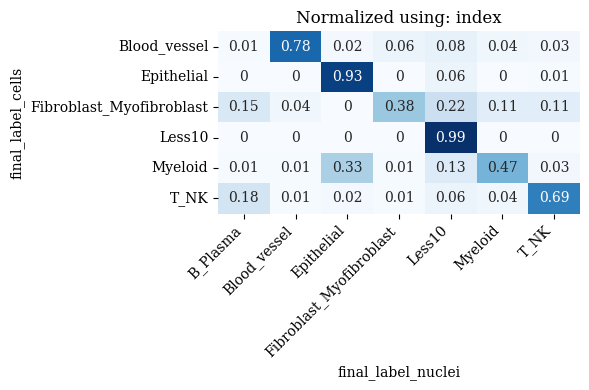

================================================== colon_s2 ==================================================


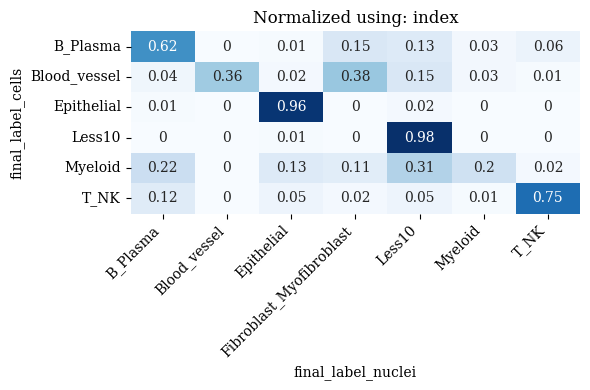

================================================== heart_s0 ==================================================


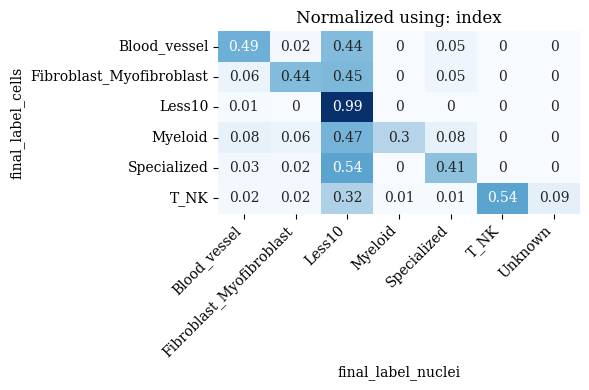

================================================== kidney_s0 ==================================================


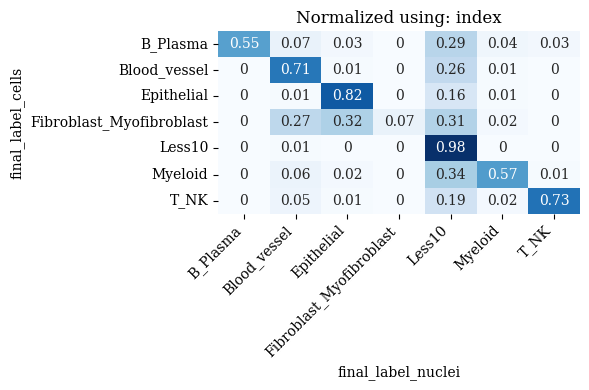

================================================== kidney_s1 ==================================================


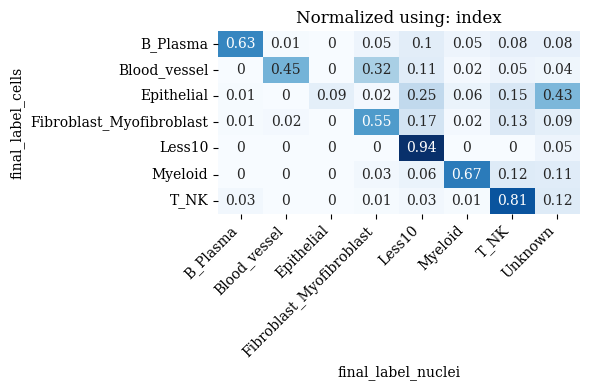

================================================== liver_s0 ==================================================


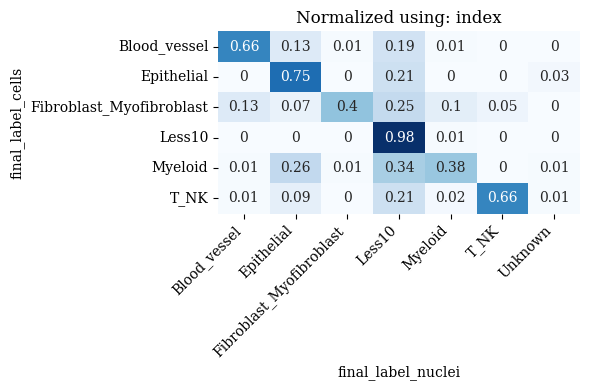

================================================== liver_s1 ==================================================


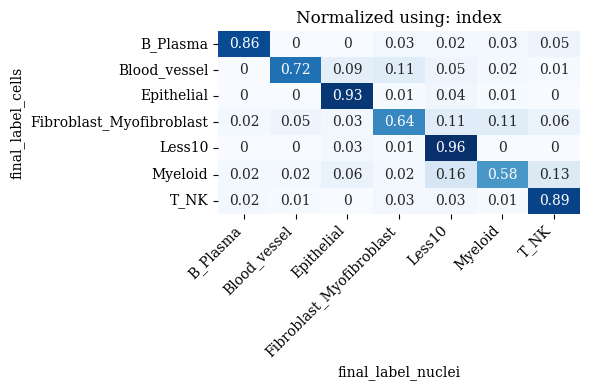

================================================== lung_s1 ==================================================


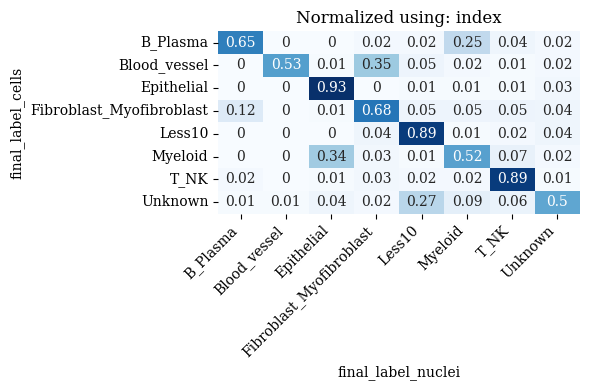

================================================== lung_s3 ==================================================


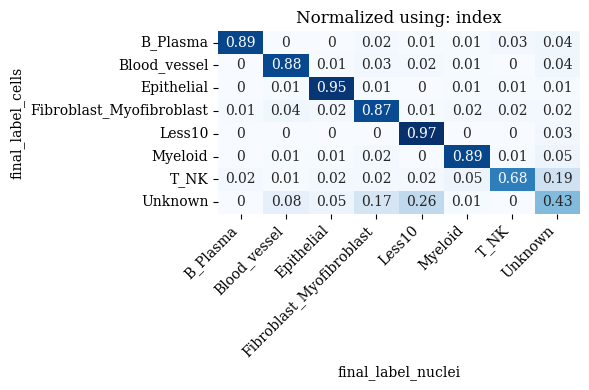

================================================== lymph_node_s0 ==================================================


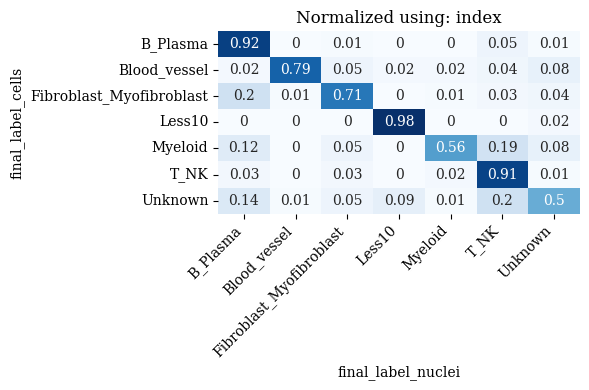

================================================== ovary_s0 ==================================================


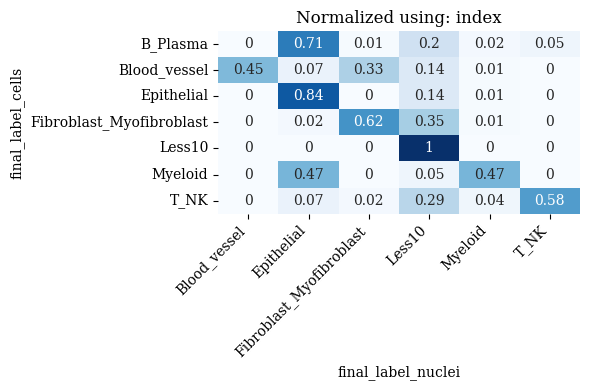

================================================== ovary_s1 ==================================================


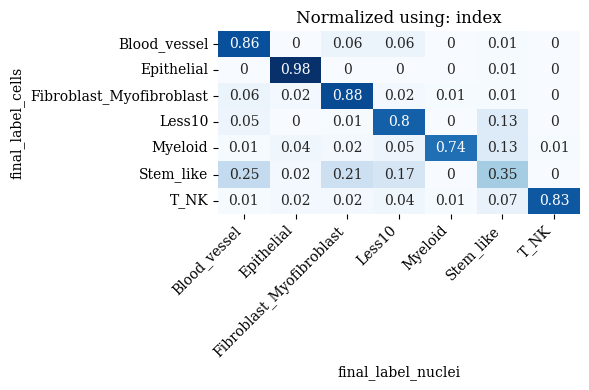

================================================== pancreatic_s0 ==================================================


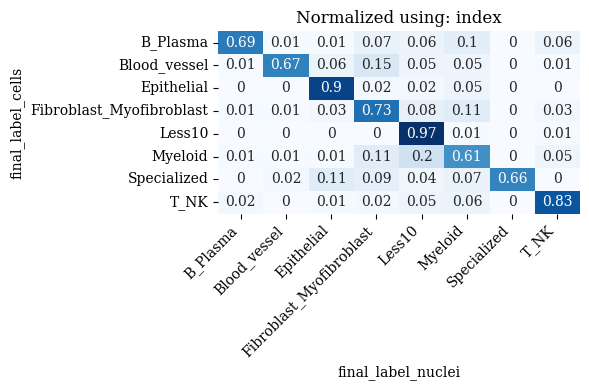

================================================== pancreatic_s1 ==================================================


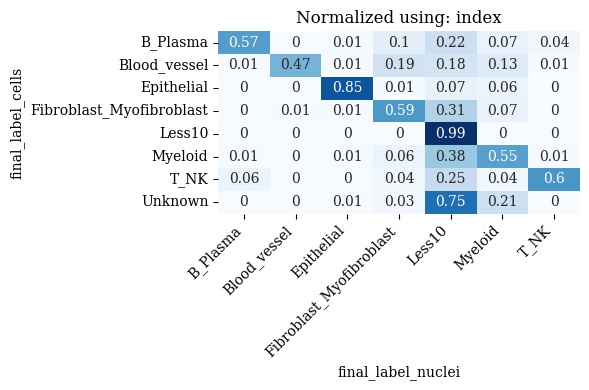

================================================== pancreatic_s2 ==================================================


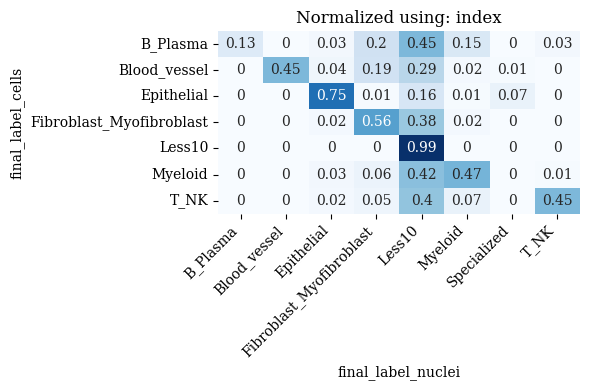

================================================== prostate_s0 ==================================================


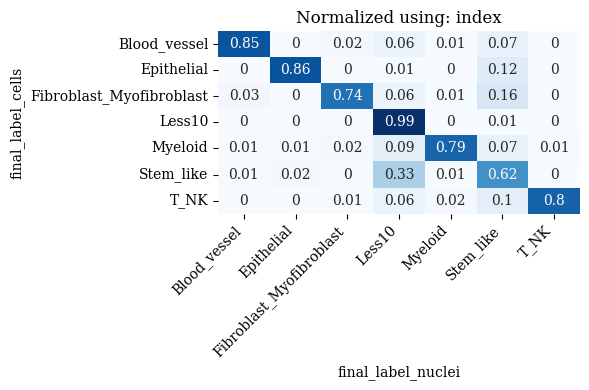

================================================== skin_s1 ==================================================


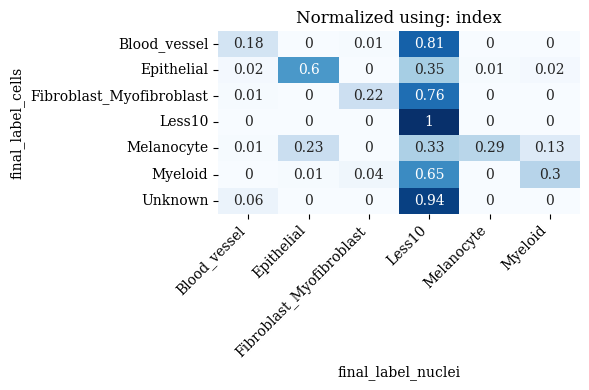

================================================== skin_s2 ==================================================


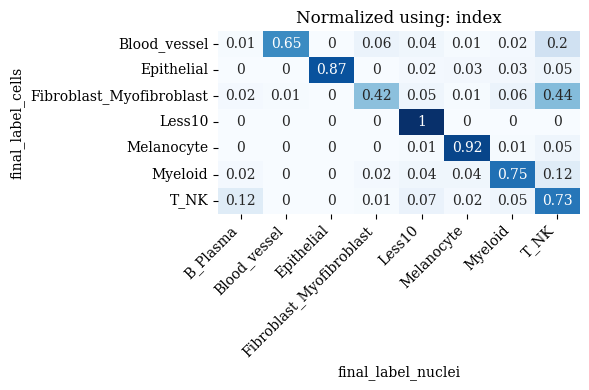

================================================== skin_s3 ==================================================


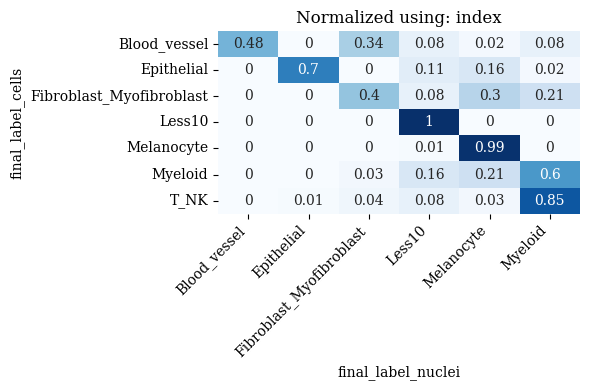

================================================== skin_s4 ==================================================


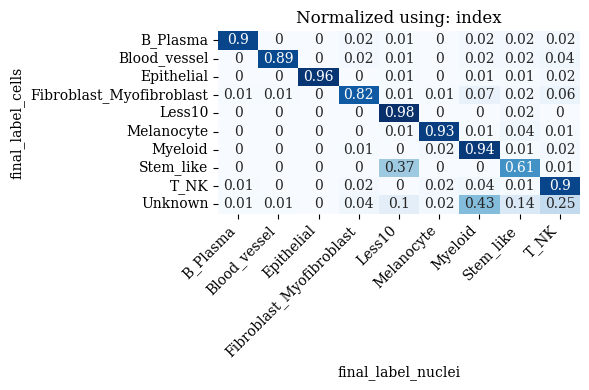

================================================== tonsil_s0 ==================================================


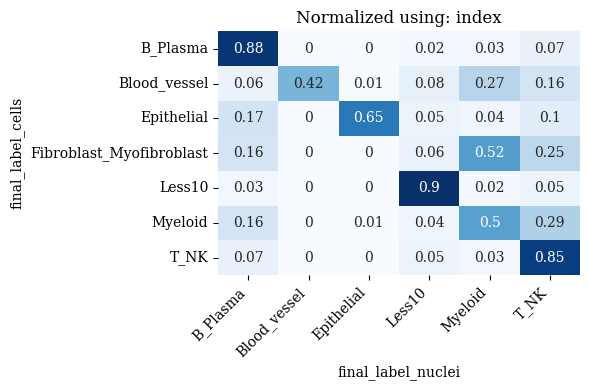

================================================== tonsil_s1 ==================================================


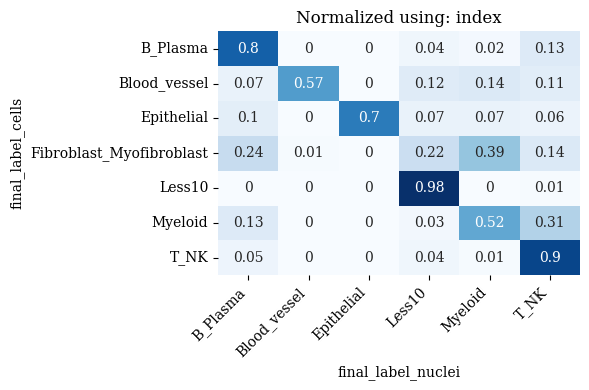

In [9]:
crosstab_heatmap(adata_obs_merge, 'final_label_cells', 'final_label_nuclei', slide_ids=[], normalize='index')

for slide_id in adata_obs_merge['slide_id'].unique():
    print('='*50 + f' {slide_id} ' + '='*50)
    crosstab_heatmap(adata_obs_merge, 'final_label_cells', 'final_label_nuclei', slide_ids=[slide_id], normalize='index')

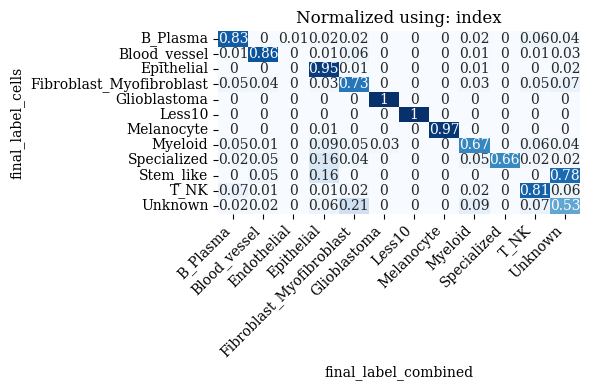

================================================== bone_marrow_s0 ==================================================


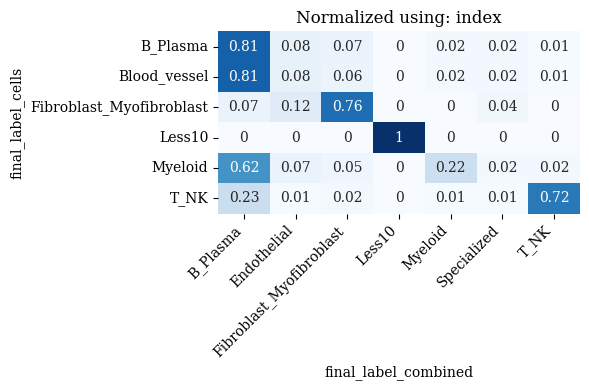

================================================== bone_marrow_s1 ==================================================


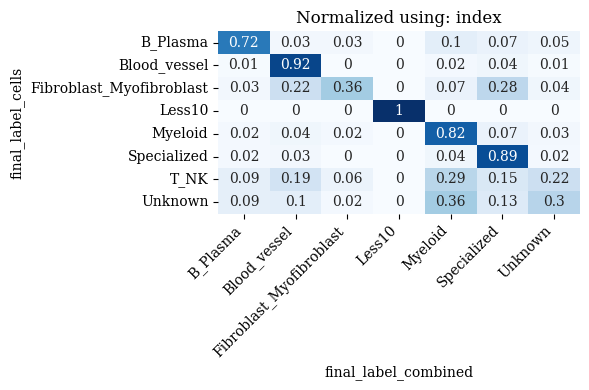

================================================== bone_s0 ==================================================


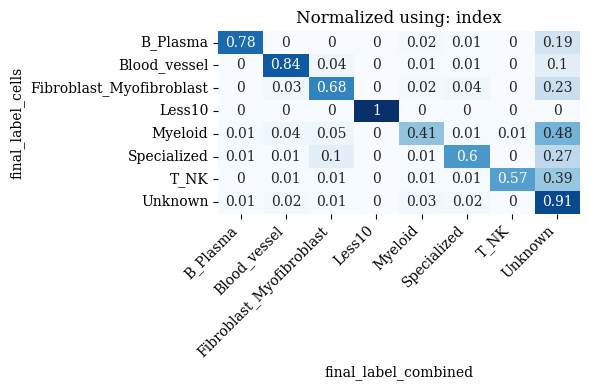

================================================== brain_s0 ==================================================


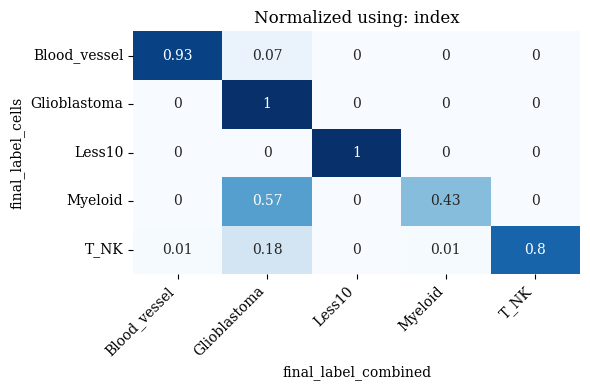

================================================== breast_s0 ==================================================


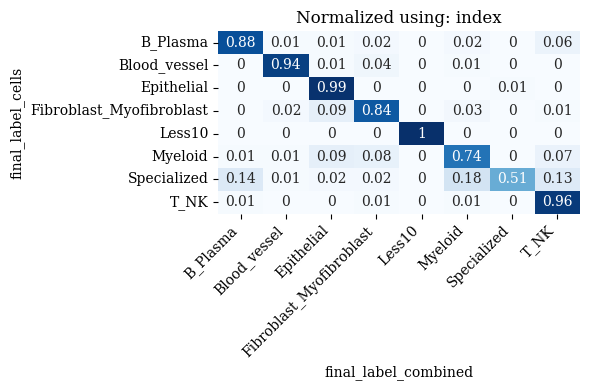

================================================== breast_s1 ==================================================


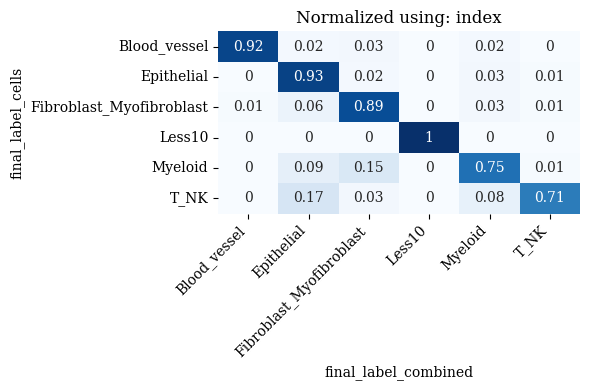

================================================== breast_s3 ==================================================


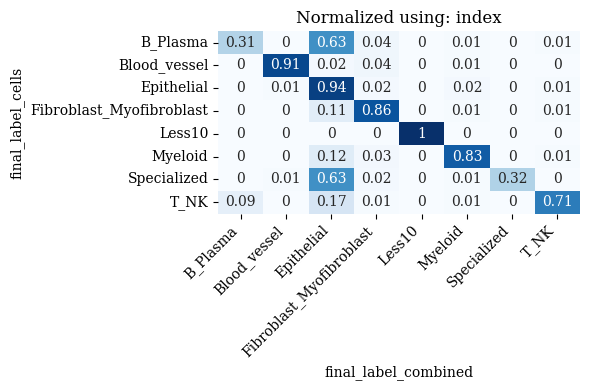

================================================== breast_s6 ==================================================


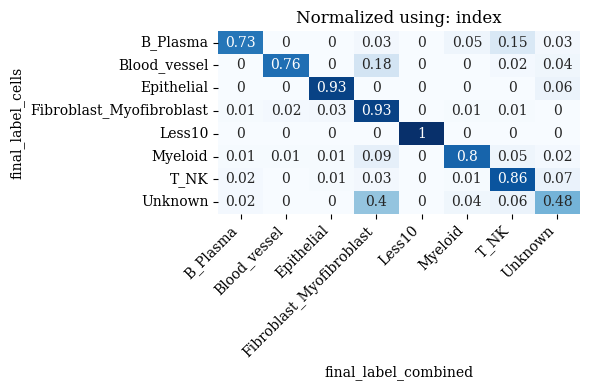

================================================== cervix_s0 ==================================================


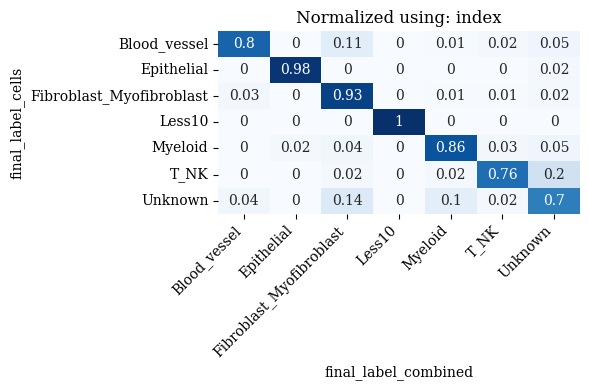

================================================== colon_s1 ==================================================


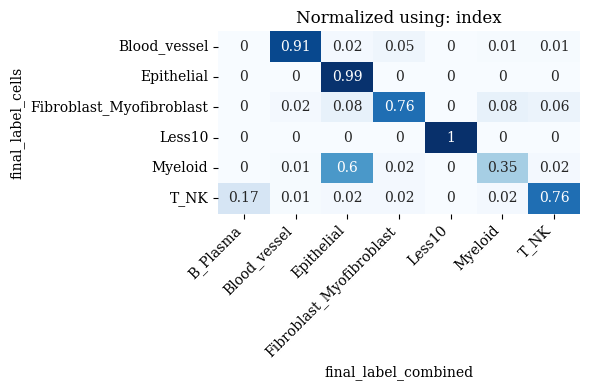

================================================== colon_s2 ==================================================


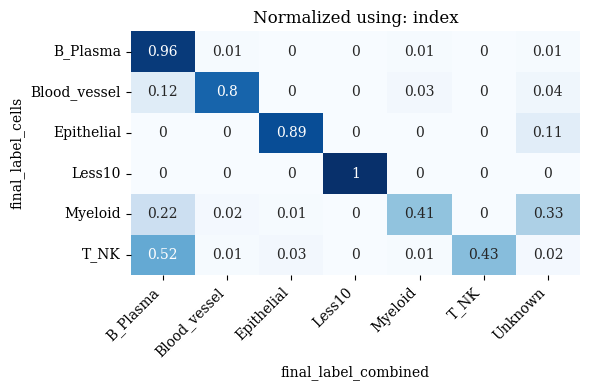

================================================== heart_s0 ==================================================


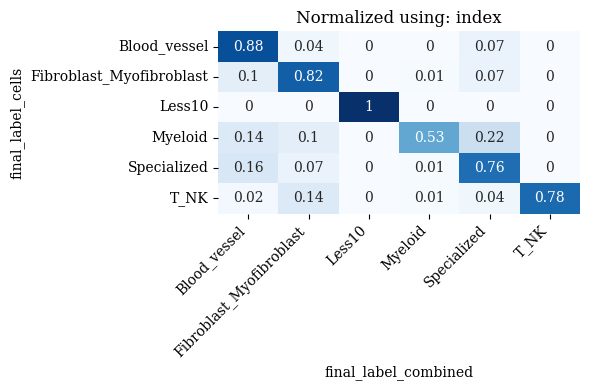

================================================== kidney_s0 ==================================================


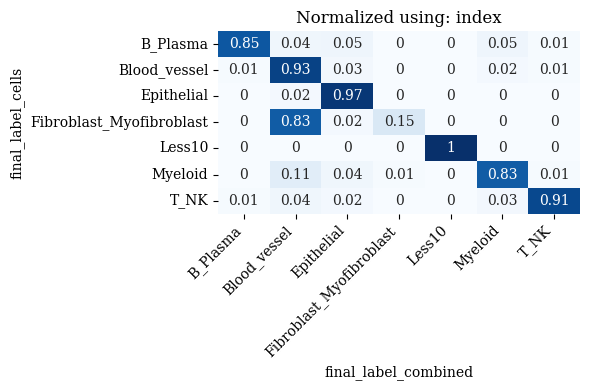

================================================== kidney_s1 ==================================================


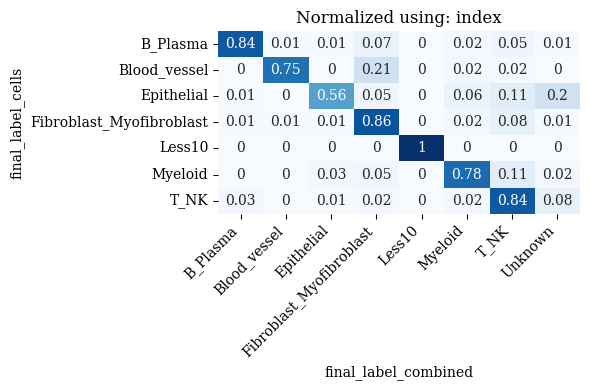

================================================== liver_s0 ==================================================


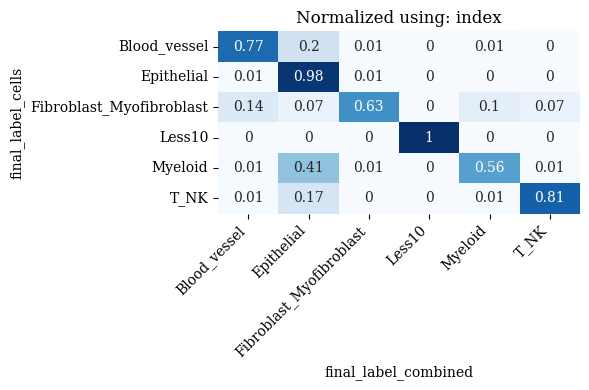

================================================== liver_s1 ==================================================


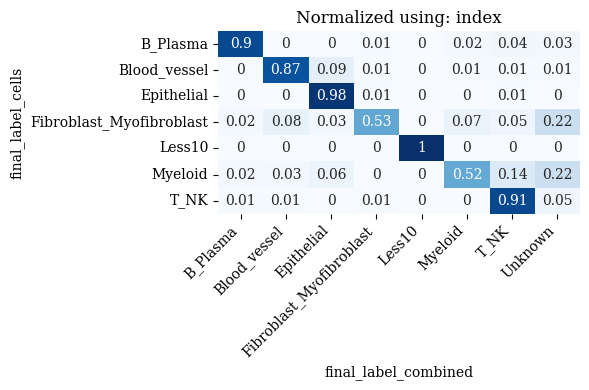

================================================== lung_s1 ==================================================


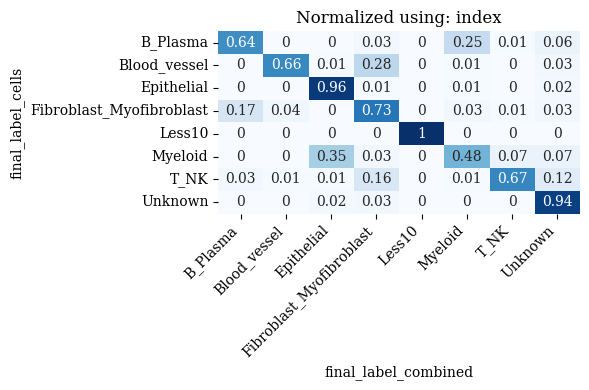

================================================== lung_s3 ==================================================


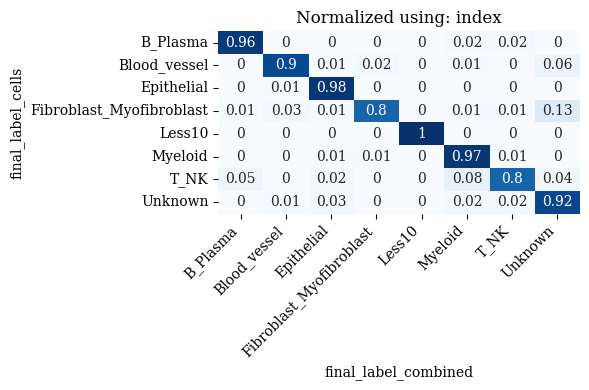

================================================== lymph_node_s0 ==================================================


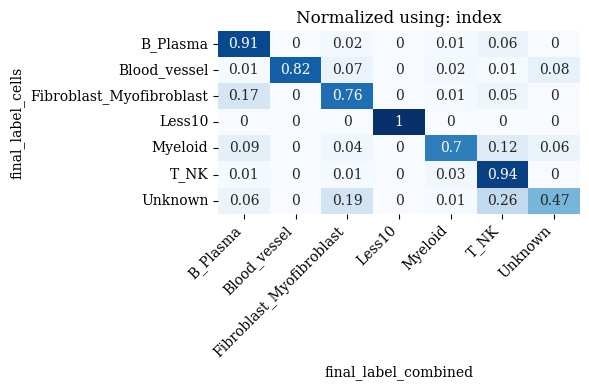

================================================== ovary_s0 ==================================================


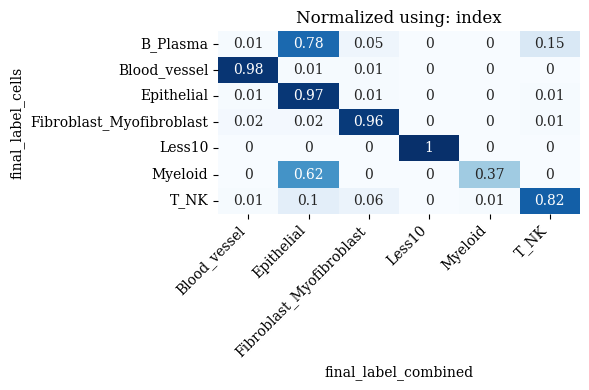

================================================== ovary_s1 ==================================================


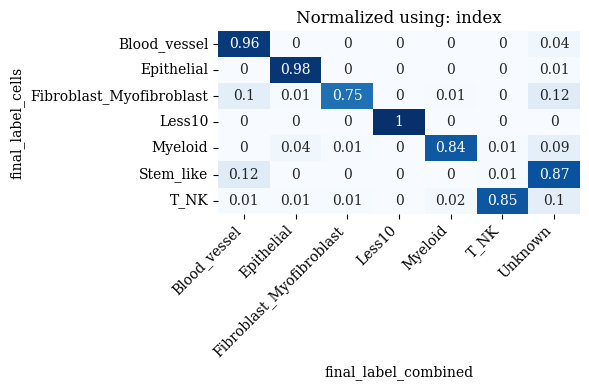

================================================== pancreatic_s0 ==================================================


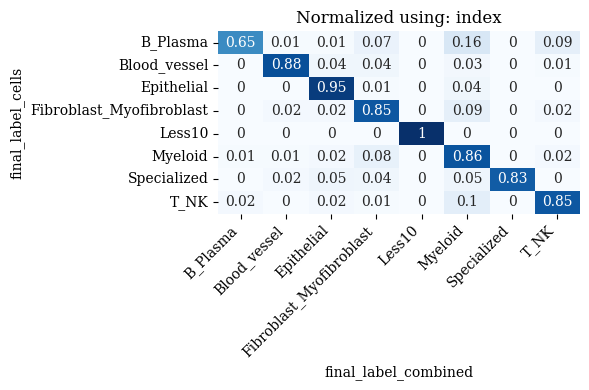

================================================== pancreatic_s1 ==================================================


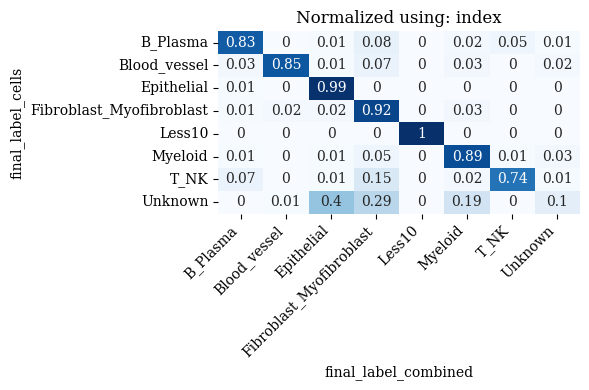

================================================== pancreatic_s2 ==================================================


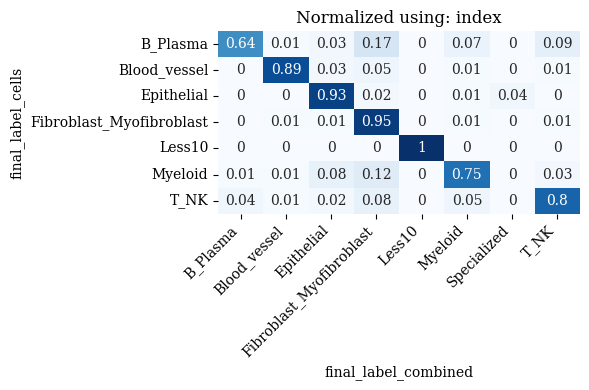

================================================== prostate_s0 ==================================================


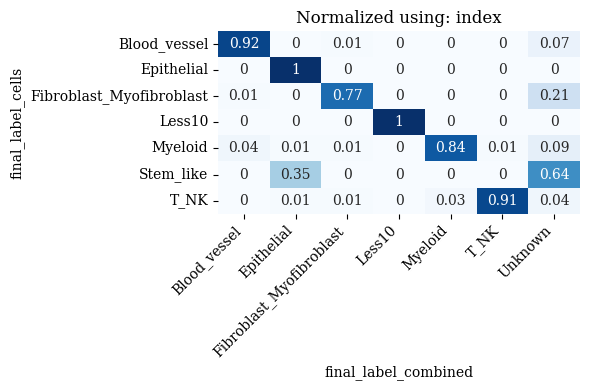

================================================== skin_s1 ==================================================


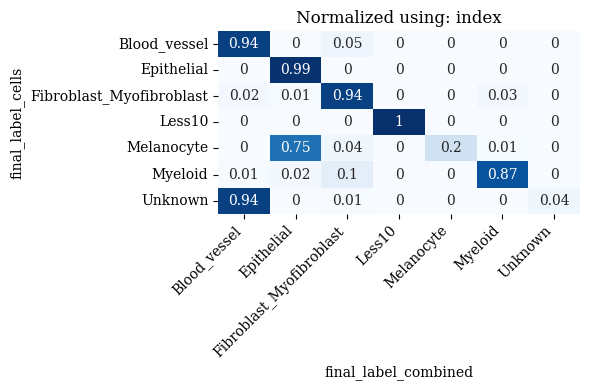

================================================== skin_s2 ==================================================


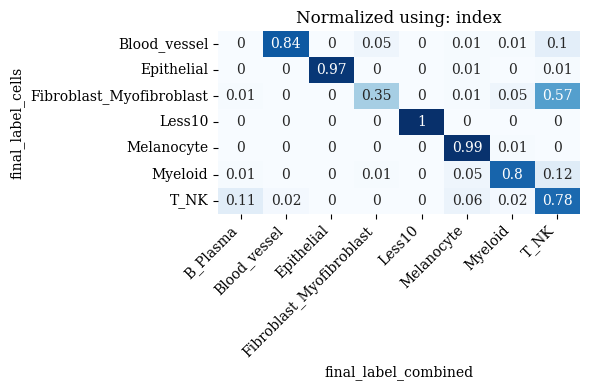

================================================== skin_s3 ==================================================


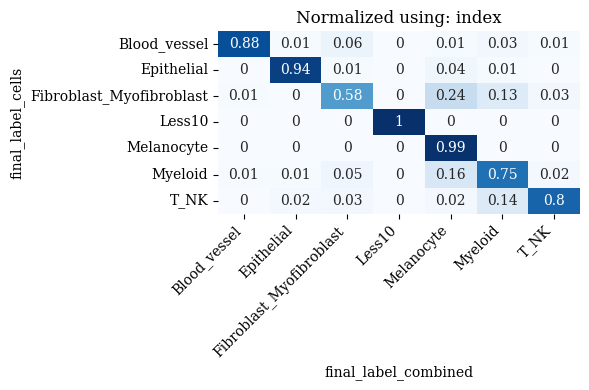

================================================== skin_s4 ==================================================


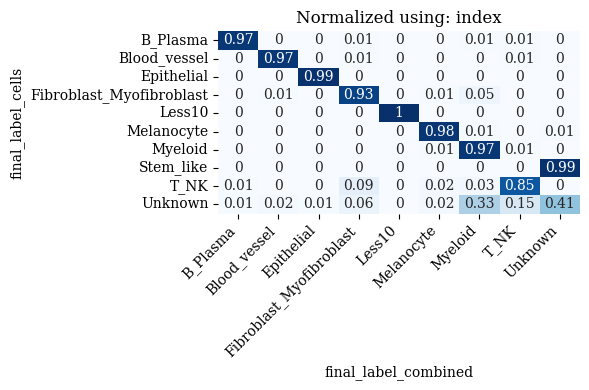

================================================== tonsil_s0 ==================================================


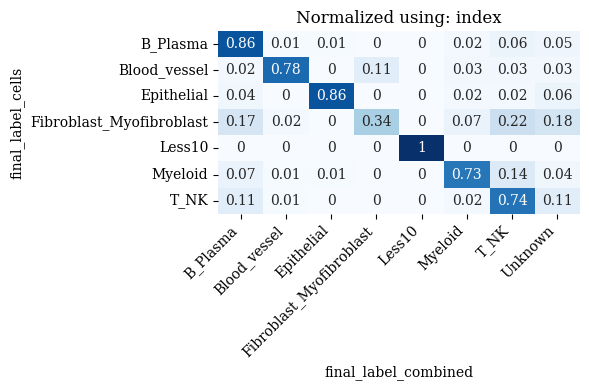

================================================== tonsil_s1 ==================================================


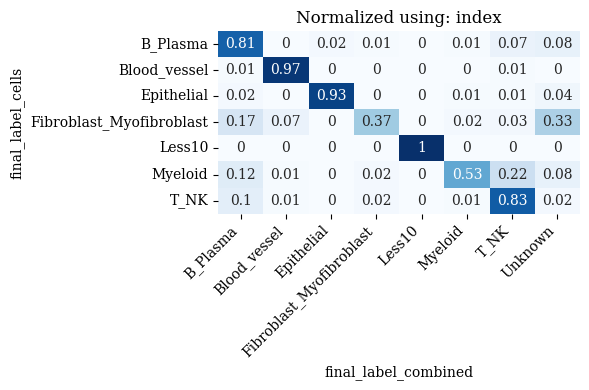

In [10]:
crosstab_heatmap(adata_obs_merge, 'final_label_cells', 'final_label_combined', slide_ids=[], normalize='index')

for slide_id in adata_obs_merge['slide_id'].unique():
    print('='*50 + f' {slide_id} ' + '='*50)
    crosstab_heatmap(adata_obs_merge, 'final_label_cells', 'final_label_combined', slide_ids=[slide_id], normalize='index')

**====> CONCLUSION:**  
**Keep final_cells but put Unknown and Stem_like as Less10, and rename Less10 as Dead.**